In [0]:
include __DIR__ . '/vendor/autoload.php';

use Gregwar\GnuPlot\GnuPlot;
use Rubix\ML\Classifiers\SVR;
use Rubix\ML\Kernels\SVM\RBF;
use Rubix\ML\Datasets\Labeled;
use Rubix\ML\Datasets\Unlabeled;


<div>
<p>
This is a (partial) PHP adaptation of this <a href="https://github.com/DrDub/riiaa20_ws25_feateng_space_time/blob/master/notebooks/2_Temporal_Time_Series-from-workshop.ipynb">Python notebook presented at a workshop in RIIAA'20</a>. The notebook in turn is adapted from Chapter 7 of <a href="http://artoffeatureengineering.com/">The Art of Feature Engineering</a>. 
</p>
<p>
This code distributed under MIT license.
</p>
</div>


<div>
<h1>Handling Time Series using Target Lags</h1>

<p>This is a small datasets for country-level population prediction based on historical data.</p>
<p>We want to predict the population of a given country in a given year. Note that there are very few countries in the world, as such we will use few features to avoid having many more parameters than training data.</p>
<p>In fact, besides the population data, we will only use two other features: the number of in links and out links for the country Wikipedia page. The idea being that larger countries might have larger Wikipedia pages (resulting in more out links) and have more Wikipedia related to them (resulting in a larger number of in links).</p>
<p>Let us start by identifying all entities of type <a href="http://dbpedia.org/ontology/Country">http://dbpedia.org/ontology/Country</a> (Cell #18).</p>
</div>


In [1]:
// from CELL 23
$rels = array();
$tsv = explode("\n", file_get_contents("ch7_cell22_rels_in_out.tsv"));
array_pop($tsv); // last
array_shift($tsv); // header
foreach($tsv as $line) {
   $parts = explode("\t", $line);
   $country = $parts[0];
   $rels_out = $parts[1];
   $rels_in = $parts[2];
   $rels[$country] = [ intval($rels_out), intval($rels_in) ];
}

$mapping = array();
$m = explode("\n", file_get_contents("ch7_cell21_wb_uri_mapping.tsv"));
array_pop($m); // last
foreach($m as $line) {
  $parts = explode("\t", $line);
  $wb = $parts[0];
  $db = $parts[1];
  //echo "$wb ". htmlspecialchars($db). "<br>";
  $mapping[$wb] = $db;
}

$data = [];
$wb = explode("\n", file_get_contents("ch7_cell19_wb_pop.tsv"));
echo "wb_pop has " . count($wb) . " lines<br>";
$line = array_shift($wb); // header
$header = explode("\t", $line);
array_splice($header, 1, 0, ["rels_out", "rels_in"]);
foreach($wb as $line) {
  $fields = explode("\t", $line);
  $wb_country = array_shift($fields);
  if(! isset($mapping[$wb_country])) {
     continue;
  }
  while($fields[count($fields)-1] == '') {
     array_pop($fields);
  }
  $db_country = $mapping[$wb_country];
  $tuple = [];
  $tuple[] = $rels[$db_country][0];
  $tuple[] = $rels[$db_country][1];
  foreach($fields as $field) { 
     if($field) {
        $tuple[] = intval($field);
     }else{
        $tuple[] = 0;
     }
  }
  $data[] = [ $wb_country, $tuple ];
}
echo "Data for " . count($data) . " countries\n";


wb_pop has 266 lines Data for 217 countries

In [2]:
// save all data
$tsv = [];
$tsv[] = implode("\t", $header);
foreach($data as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_data.tsv", implode("\n", $tsv)."\n");

// split train and final test
mt_srand(42);

// Fisher-Yates shuffle as PHP shuffle is self-seeded
for ($i = count($data) - 1; $i > 0; $i--) {
  $j = mt_rand(0, $i);
  $tmp = $data[$i];
  $data[$i] = $data[$j];
  $data[$j] = $tmp;
}
$pivot = intval(count($data) * 0.8);
$devset = array_slice($data, 0, $pivot);
$heldout = array_slice($data, $pivot);
$tsv = [];
$tsv[] = implode("\t", $header);
foreach($devset as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_dev.tsv", implode("\n", $tsv)."\n");

$tsv = [];
$tsv[] = implode("\t", $header);
foreach($heldout as $pair) {
  $line = $pair[0];
  foreach($pair[1] as $point) {
     $line .= "\t" . $point;
  }
  $tsv[] = $line;
}
file_put_contents("cell23_countries_held.tsv", implode("\n", $tsv)."\n");

echo "<br>Devset size:  " . count($devset);
echo "<br>Heldout size: " . count($heldout);



Devset size: 173 Heldout size: 44

<div>
<p>With the data split properly, we can start some EDA on it.</p>

<h2>EDA</h2>

<p>Let's plot the relations and current population to see if there is a correlation (Cell #24).</p>

</div>


In [3]:
// from CELL 24

$pops = [];
$num_in_rels = [];
$num_out_rels = [];
foreach($devset as $pair) {
  $fields = $pair[1];
  $pop = floatval($fields[count($fields)- 1]);
  $out_rels = floatval($fields[1]);
  $in_rels = floatval($fields[2]);
  if($out_rels == 0){
     continue;
  }
  $pops[] = log($pop, 10);
  $num_out_rels[] = log($out_rels, 10);
  $num_in_rels[] = log($in_rels, 10);
}




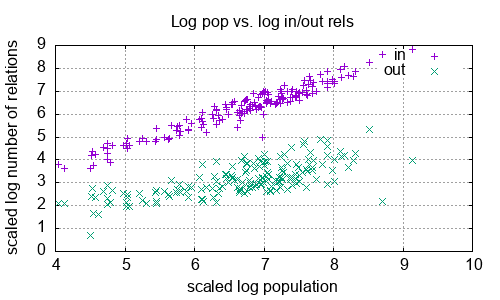

In [4]:
class MyPlot extends GnuPlot {
    public function __construct() {
        parent::__construct();
        $this->mode = 'points';
    }
    protected function sendCommand($command) {
        //echo "$command\n<br>\n";
        parent::sendCommand($command);
    }
    public function get($format = self::TERMINAL_PNG) {
        $this->sendInit();
        $this->sendCommand("set terminal $format size {$this->width}{$this->unit}, {$this->height}{$this->unit}");
        fflush($this->stdout);
        $this->plot();

        // Reading data, timeout=500ms
        $result = '';
        $timeout = 500;
        do {
            stream_set_blocking($this->stdout, false);
            $data = fread($this->stdout, 128);
            $result .= $data;
            usleep(10000);
            $timeout -= 5;
        } while ($timeout > 0 || $data);

        return $result;
    }
}
$plot = new MyPlot;

$plot
  ->setGraphTitle('Log pop vs. log in/out rels')
  ->setXLabel('scaled log population')
  ->setYLabel('scaled log number of relations')
  ->setWidth(500)
  ->setHeight(300);
$plot->setTitle(0, 'in');
for($idx=0; $idx<count($pops); $idx++) {
  $plot->push($pops[$idx], $num_in_rels[$idx]);
}
$plot->setTitle(1, 'out');
for($idx=0; $idx<count($pops); $idx++) {
  $plot->push($pops[$idx], $num_out_rels[$idx], 1);
}
//$plot->display();
$png = $plot->get();
$base64 = 'data:image/png;base64,' . base64_encode($png);

echo "<img src='$base64'/>";




<div>
<p>From the figure we can see that the number of in relations is informative, but the number of out relations is not, most of the countries are involved in the same number of standard relations.</p>

<p>Let us now take 10 random countries and look at their time series data (Cell #25).</p>
</div>


,
,
,
,
,
,

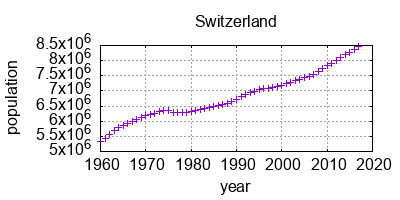
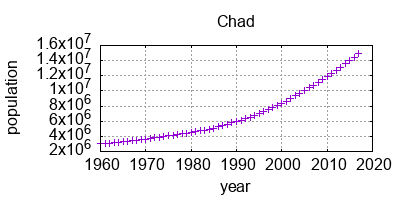
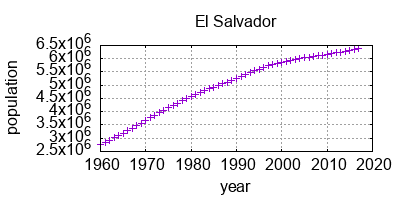
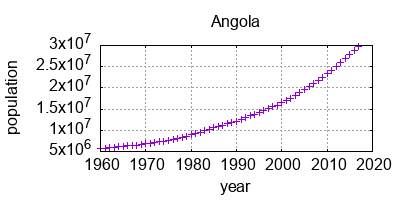
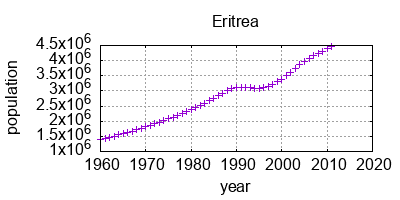
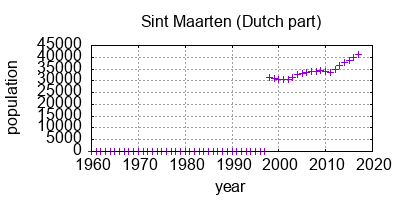
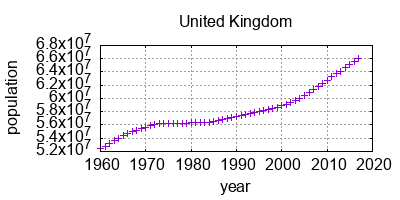
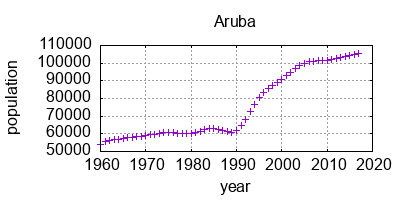
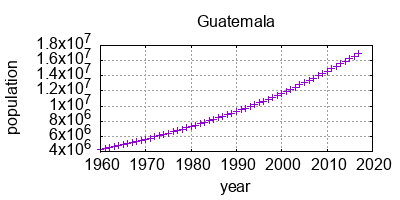
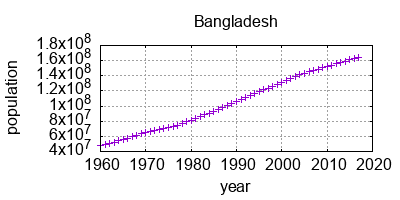
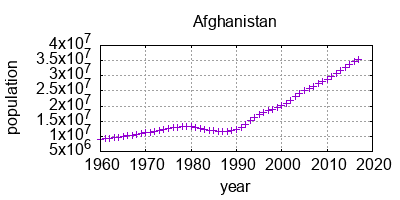
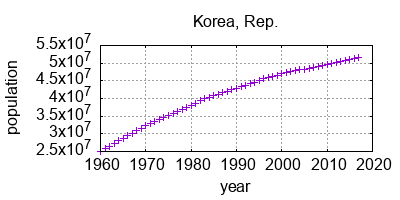

In [5]:
// from CELL 25

$indices = [];
for($idx=0; $idx<count($devset); $idx++){
  $indices[]=$idx;
}
mt_srand(42);
for ($i = count($indices) - 1; $i > 0; $i--) {
  $j = mt_rand(0, $i);
  $tmp = $indices[$i];
  $indices[$i] = $indices[$j];
  $indices[$j] = $tmp;
}
$to_show=[];

$years=[];
for($idx=3;$idx<count($header); $idx++){
  $years[]= intval($header[$idx]);
}

echo '<table>';

for($idx=0;$idx<12; $idx++){
  $pair=$devset[$indices[$idx]];
  if($idx % 2 == 0) { 
    echo '<tr>';
  }
  $plot=new MyPlot;
  $plot
    ->setGraphTitle($pair[0])
    ->setXLabel('year')
    ->setYLabel('population')
    ->setWidth(400)
    ->setHeight(200)
    ->setTitle(0, "");
   for($idx2=2; $idx2<count($pair[1]); $idx2++) {
     $plot->push($years[$idx2-2], $pair[1][$idx2]);
   }
   $png = $plot->get();
   $base64 = 'data:image/png;base64,' . base64_encode($png);

   echo "<td><img src='$base64'/></td>";
   if($idx % 2 == 1) {
      echo '</tr>'."\n";
   }
}
echo '</table>'."\n";





<div>
<p>In the figure we can see trend reversal, missing data (Sint Maarten) and a variety of curves.
</p>
</div>


<div>
<h1>No TS data</h1>
<p>
Let us start by using only the number of relations (Cell #33) and the year.
</p>
</div>
